# Environment

In [1]:
!cd ../&& pip install . | tail -n 3 &&cd -

    Uninstalling TEXTURElib-1.0:
      Successfully uninstalled TEXTURElib-1.0


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload
from TX import upf, bcc_rolling_fiber, sym
import numpy as np
from matplotlib.gridspec import GridSpec
#from shapely import geometry
#from shapely.geometry import Point, Polygon
import scipy
import matplotlib
from scipy.interpolate import griddata
plt=matplotlib.pyplot
#vector_ang=bcc_rolling_fiber.vector_ang
#projection=upf.projection
#get_icsym=sym.get_icsym

def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes

In [3]:
# !cd ../&& pip install . | tail -n 3 &&cd -

#kw=dict(miller=[1,1,1],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx')
kw=dict(miller=[1,0,-1,2],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')
kw=dict(miller=[1,1,-2,2],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')
kw=dict(miller=[0,0,1],fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx')
#!cd ../&& pip install . | tail -n 3 &&cd -
sym.calc_cvec(**kw)

#sym.read_fnsx(fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')

array([0., 0., 1.])

# Visualizing PFs, IPFs

    Uninstalling TEXTURElib-1.0:
      Successfully uninstalled TEXTURElib-1.0
Elapsed time for calling cells_pf:          37 [ ms]

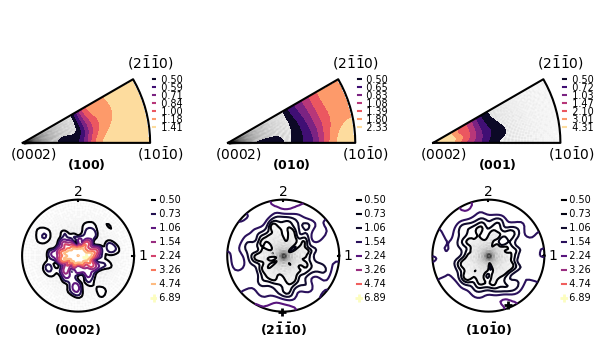

In [4]:
!cd ../&& pip install . | tail -n 3 &&cd -
from TX import upf
%autoreload


if True:
    filename='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/AZ31_500.tex'
    grs=np.loadtxt(filename,skiprows=4)
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx'
    csym, cdim, cang = sym.read_fnsx(fnsx)
#    a=[0,0,0,2];b=[1,0,-1,0];c=[2,-1,-1,0]
    a=[0,0,0,2];b=[2,-1,-1,0];c=[1,0,-1,0]
    cpoles=[[0,0,0,2],[2,-1,-1,0],[1,0,-1,0]]
if False:
    a=[0,0,1];b=[1,0,1];c=[1,1,1] ## boundary
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx'
    csym, cdim, cang = sym.read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/EDDQ100'
    grs=np.loadtxt(filename,skiprows=4)
    cpoles=[[1,0,0],[1,1,0],[1,1,1]]
if False:
    a=[0,0,1];b=[1,0,0];c=[0,1,0] ## boundary
    fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx'
    csym,cdim,cang=sym.read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/examples/ex01_elast/U_clock.tex'
    grs=np.loadtxt(filename,skiprows=4)    
    cpoles=[[1,0,0],[0,1,0],[1,0,1]]    
    
poles=[[1,0,0],[0,1,0],[0,0,1]] ## inverse poles
fig,axes=gen_fig(ncols=len(poles),nrows=2)#,rowsize=1.0)
dth=7.5; dph=7.5
mypf=upf.polefigure(grains=grs[:,:],fnsx=fnsx)#csym=csym,cang=cang,cdim=cdim)
triangle=upf.get_ipf_boundary(fnsx=fnsx,a=a,b=b,c=c,nres=10)
circle=upf.__circle__()
for ip, pole in enumerate(poles): 

    dth=10; dph=10
    mypf.pf_new(axs=axes[0,ip:ip+1].flatten(),mode='fill',proj='ipf',
                poles=[poles[ip]],dth=dth,dph=dph,ismooth=10,mn=0.5)
    pass
## deco
for i, ax in enumerate(axes[:-1,:].flatten()):
    #ax.set_axis_off()
    #ax.plot(*triangle,zorder=10,c='k')
    ax.set_aspect('equal')
    #ax.plot(*upf.__circle__(),'-k')
for i, ax in enumerate(axes[:-1,:].flatten()):
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

if False:
    for j, miller in enumerate([a,b,c]):
        x,y=upf.projection(-sym.calc_cvec(miller=miller,fnsx=fnsx))
        t=''
        for i, v in enumerate(miller):
            #if v>0: t='%i'%v
            if v<0: tx=r'\bar{%i}'%-v
            else: tx='%i'%v
            t=f'{t}%s'%tx
        t=rf'$({t})$'
        if j<2 : loc=(x,y-0.1)
        if j==2: loc=(x,y+0.1)
        print(f'\n(x,y): ({x,y}), loc: {loc}')
        axes[0,-1].text(*loc,t,va='center',ha='center')
    

## plot pole figures
mypf.pf_new(axs=axes[-1,:],poles=cpoles,dth=dth,dph=dph,csym=csym,cang=cang,cdim=cdim,ismooth=3)

Elapsed time for calling cells_pf:          13 [ ms]

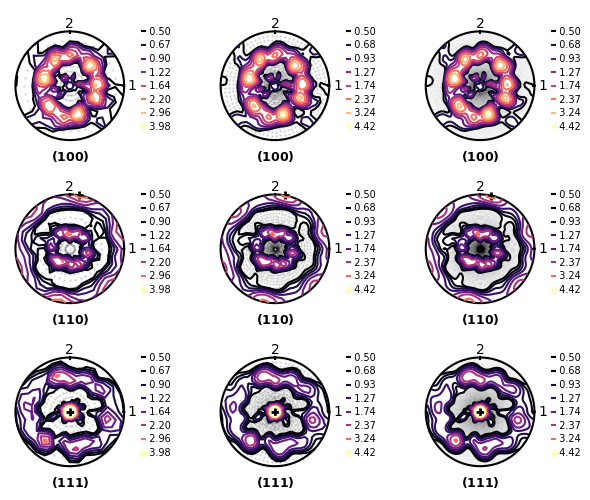

In [5]:
if True:
    filename='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/AZ31_500.tex'
    grs=np.loadtxt(filename,skiprows=4)
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx'
    csym, cdim, cang = sym.read_fnsx(fnsx)
#    a=[0,0,0,2];b=[1,0,-1,0];c=[2,-1,-1,0]
    a=[0,0,0,2];b=[2,-1,-1,0];c=[1,0,-1,0]
    cpoles=[[0,0,0,2]]
if True:
    a=[0,0,1];b=[1,0,1];c=[1,1,1] ## boundary
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx'
    csym, cdim, cang = sym.read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/EDDQ100'
    grs=np.loadtxt(filename,skiprows=4)
    cpoles=[[1,0,0],[1,1,0],[1,1,1]]
if False:
    a=[0,0,1];b=[1,0,0];c=[0,1,0] ## boundary
    fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx'
    csym,cdim,cang=sym.read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/examples/ex01_elast/U_clock.tex'
    grs=np.loadtxt(filename,skiprows=4)    
    cpoles=[[1,0,0],[0,1,0],[1,0,1]]
    
smooths=[1,2,5]

fig,axes=gen_fig(nrows=len(cpoles),ncols=len(smooths))#,rowsize=1.0)
dth=10; dph=10
mypf=upf.polefigure(grains=grs[:,:],fnsx=fnsx)
for i, ismooth in enumerate(smooths):
    mypf.pf_new(axs=axes[0:len(cpoles),i:i+1].flatten(),poles=cpoles,dth=dth,dph=dph,ismooth=ismooth,mn=0.5)

    Uninstalling TEXTURElib-1.0:
      Successfully uninstalled TEXTURElib-1.0
Elapsed time for calling cells_pf:          44 [ ms]

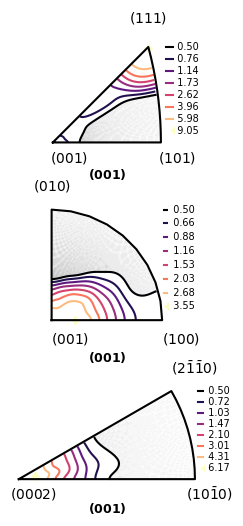

In [6]:
!cd ../&& pip install . | tail -n 3 &&cd -
from TX import upf
%autoreload

smooths=[10]
fig,axes=gen_fig(nrows=3,ncols=len(smooths),hspace=0.4,wspace=0.3)#,rowsize=1.0)
for icase in range(3):
    if icase==0:
        a=[0,0,1];b=[1,0,1];c=[1,1,1] ## boundary
        fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx'
        csym, cdim, cang = sym.read_fnsx(fnsx)
        filename='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/EDDQ100'
        grs=np.loadtxt(filename,skiprows=4)
        cpoles=[[1,0,0],[1,1,0],[1,1,1]]
    if icase==1:
        a=[0,0,1];b=[1,0,0];c=[0,1,0] ## boundary
        fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx'
        csym,cdim,cang=sym.read_fnsx(fnsx)
        filename='/Users/youngung/repo/evpsc/examples/ex01_elast/U_clock.tex'
        grs=np.loadtxt(filename,skiprows=4)    
        cpoles=[[1,0,0],[0,1,0],[1,0,1]]    
    if icase==2:
        filename='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/AZ31_500.tex'
        grs=np.loadtxt(filename,skiprows=4)
        fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx'
        csym, cdim, cang = sym.read_fnsx(fnsx)
        a=[0,0,0,2];b=[2,-1,-1,0];c=[1,0,-1,0]
        cpoles=[[0,0,0,2]]

    dth=10; dph=10
    mypf=upf.polefigure(grains=grs[:,:],fnsx=fnsx)
    for i, ismooth in enumerate(smooths):
        mypf.pf_new(axs=axes[icase,i:i+1].flatten(),mode='line',proj='ipf',
                    poles=[[0,0,1]],dth=dth,dph=dph,ismooth=ismooth,mn=0.5)
fig.savefig('/tmp/pf.pdf')
!open /tmp/pf.pdf